In [13]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
from matplotlib import pyplot as plt

In [2]:
conn = psycopg2.connect(dbname="local_density", user="adi", password="password")

In [3]:
SELECT = """
    SELECT d.client_count, d.dump_time,
           r.id AS group_id, r.name AS group_name,
           b.id AS parent_id, b.name AS building_name
    FROM density_data d
    JOIN routers r ON r.id = d.group_id
    JOIN buildings b ON b.id = r.building_id"""

In [4]:
def db_to_pandas(conn):
    """ Return occupancy data as pandas dataframe
    column dtypes:
        group_id: int64
        group_name: category
        parent_id: int64
        parent_name: category
        client_count: int64
    index: DateTimeIndex -- dump_time
    Parameters
    ----------
    conn: psycopg2.extensions.connection
        Connection to db
    Returns
    -------
    pandas.DataFrame
        Density data in a Dataframe
    """

    df = pd.read_sql(SELECT, conn) \
           .set_index("dump_time") \
           .assign(group_name=lambda df: df["group_name"].astype('category'),
                   parent_id=lambda df: df["parent_id"].astype('category'))
    df['week'] = df.index.weekofyear  # get week of the year for a given timestamp
    df['weekday'] = df.index.weekday  # 
    df['time'] = df.index.time
    time_points = zip(df.index.hour, df.index.minute)
    time_points = ["{}:{}".format(x[0], x[1]) for x in time_points]
    df["time_point"] = time_points
    
    return df


In [5]:
def parse_by_week(df):
    weeks = np.unique(df['week'])
    week_dic = dict.fromkeys(weeks)
    
    for week in weeks:
        week_dic[week] = df[df['week'] == week]
    
    return week_dic

In [6]:
def predict_tomorrow(day_dict):
    tomorrow = datetime.datetime.today() + datetime.timedelta(days=1)
    day_of_week = tomorrow.weekday()
    week_of_year = tomorrow.isocalendar()[1]
    
    past_data = day_dict[week_of_year]
    past_data = past_data[past_data['weekday'] == day_of_week]
    
    results, locs = [], []
    for group in np.unique(past_data["group_name"]):
        locs.append(group)
        group_data = past_data[past_data["group_name"] == group]
        group_data = group_data[["client_count", "time_point"]]
        group_result = group_data.groupby("time_point").mean()
        results.append(group_result.transpose())
    result = pd.concat(results)
    result.index = locs
    result = result.transpose()
    
    old_indexes = result.index
    new_indexes = []

    for index in old_indexes:
        splited = index.split(":")
        leading, trailing = splited[0], splited[1]
        if len(leading) == 1:
            leading = "0" + leading
        new_index = leading + ":" + trailing
        new_indexes.append(new_index)

    result.index = new_indexes
    result = result.sort_index()
    
    return result

In [7]:
data = db_to_pandas(conn)

In [8]:
by_week = parse_by_week(data)

In [9]:
tp = predict_tomorrow(by_week)

In [11]:
tp

,Architectural and Fine Arts Library 1,Architectural and Fine Arts Library 2,Architectural and Fine Arts Library 3,Butler Library 2,Butler Library 3,Butler Library 301,Butler Library 4,Butler Library 5,Butler Library 6,Butler Library stk,...,Lehman Library 3,Lerner 1,Lerner 2,Lerner 3,Lerner 4,Lerner 5,Roone Arledge Auditorium,Science and Engineering Library,Starr East Asian Library,Uris/Watson Library
00:0,2.0,6.0,1.0,117.5,109.5,98.0,63.5,8.5,0.0,12.5,...,3.0,27.0,35.0,24.0,9.0,45.5,93.5,24.5,8.5,3.0
00:15,2.0,6.0,0.5,112.0,97.0,89.0,51.0,8.5,1.0,11.5,...,3.5,2.5,44.0,24.0,9.0,50.0,93.5,19.5,5.5,3.0
00:30,2.0,5.0,2.0,100.5,94.0,72.0,43.5,9.5,0.0,9.5,...,3.0,1.0,37.0,21.5,11.5,44.0,87.0,12.5,5.5,2.5
00:45,1.5,5.5,0.5,78.0,91.0,68.0,40.5,10.5,0.0,8.5,...,2.5,0.0,25.5,20.5,7.5,32.5,82.0,11.0,4.5,3.0
01:0,1.0,6.0,0.5,85.5,79.5,64.0,32.0,13.5,2.0,7.5,...,2.5,0.5,31.5,20.0,7.0,30.5,80.5,6.0,3.0,3.0
01:15,1.0,7.0,1.0,67.0,68.0,43.0,26.0,8.5,1.5,7.0,...,2.5,0.5,25.0,15.0,6.0,27.5,74.0,2.0,3.0,4.0
01:30,1.0,6.0,1.0,65.5,68.5,30.0,23.0,13.0,1.0,5.5,...,3.0,0.5,25.5,21.5,7.0,31.0,68.5,1.5,2.0,3.5
01:45,1.5,5.5,0.5,53.5,55.0,27.0,22.0,7.5,1.0,5.5,...,2.5,0.5,28.0,15.0,5.0,24.5,65.0,2.0,4.0,3.0
02:0,1.5,6.5,1.0,46.5,47.0,30.0,19.0,12.5,1.0,5.0,...,3.0,0.5,25.5,12.5,5.5,18.0,56.0,2.0,2.0,3.5
02:15,1.0,6.0,1.0,44.0,41.0,28.0,17.0,8.5,1.0,4.0,...,3.5,0.0,28.0,11.0,4.0,16.0,40.0,1.0,2.0,3.0


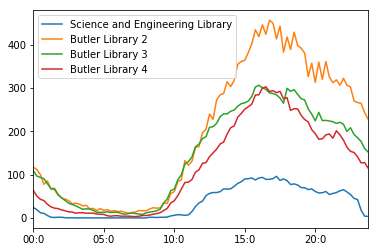

In [15]:
tmp = tp[['Science and Engineering Library', 'Butler Library 2', 'Butler Library 3', 'Butler Library 4']]
tmp.plot()
plt.show()